In [1]:
%matplotlib widget
import virtuosopy as vp

# This creates (or overwrites if it exists) a schematic called example_circuit under the vp_demonstration library
# If overwrite=True is not there and you try to create an instance that already exists you will get an error.
sch = vp.Schematic('vp_demonstration', 'example_circuit', overwrite=True)

# create a nmos and print its details
nmos = sch.create_instance('analogLib', 'nmos4', [0.,0.], 'nmos')

#  apply a width, length, and model
nmos['w'] = '0.5u'
nmos['l'] = '1u'
nmos['model'] = 'nfet'
print(nmos)

# connect the body to the source
# sch.create_wire('route', [ns[-1].pins.S, ns[-1].pins.S.pos + [0.,-2.]], 'gnd!')
sch.create_wire('route', [nmos.pins.B, nmos.pins.B.pos + [2., -0.]], 'gnd!')

# create a resistor above the nmos connected to the drain
R1 = sch.create_instance('analogLib', 'res', ([nmos.pins.D, 'MINUS'], 'above'), 'R1', conn_name='r_bot')
R1['r'] = '1k'

# create a resistor below the nfet connected to the source
R2 = sch.create_instance('analogLib', 'res', ([nmos.pins.S, 'PLUS'], 'below'), 'R2')
R2['r'] = '10k'

# connect pins to the loose ends
pin_G = sch.create_pin('G', 'input', (nmos.pins.G, 'left', 2))
pin_D = sch.create_pin('D', 'input', (R1.pins.PLUS, 'above', 2), 'R270')
pin_S = sch.create_pin('S', 'input', (R2.pins.MINUS, 'below', 2), 'R90')

if sch.save():
    print('error saving')
else:
    print('Save successful')



Instance Name:
	nmos
Library Name:
	analogLib
Cell Name:
	nmos4
Pin Names: 
	B, D, G, S, 
Parameter Names: 
	model, w, l, as, ad, ps, pd, nrd, nrs, ld, ls, m, trise, geo, rdc, rsc, sa, sb, sd, region, degradation, off, Vds, Vgs, Vbs, dtemp, 
Applied Paramters: 
	w = 0.5u
	l = 1u
	model = nfet

Save successful


Skill response:0: UserWarning:  The display packet information '90' for 'display' was not found.


Setting up Simulation...


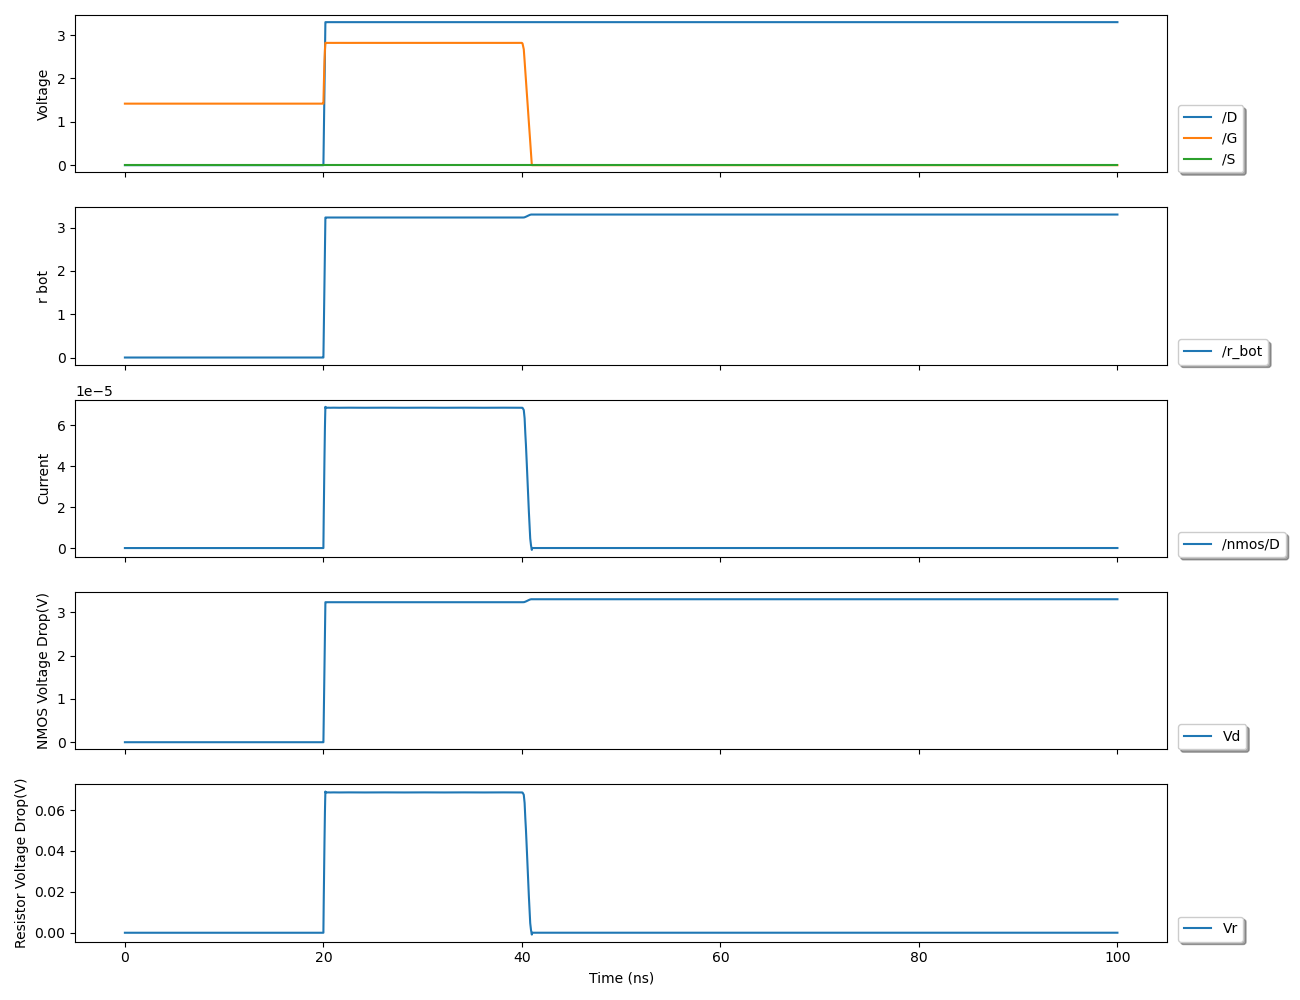

In [2]:
# Setup Simulator
print('Setting up Simulation...')
model_files = ['../model/FinFET/14nfet.pm']

# simulate for 100ns
s = vp.Simulator('100n', sch, model_files)

# setup stimuli
stims = {}

# Piecewise linear voltage stimulus 
stims['D'] = {'type' : 'pwl', 'wave' : vp.create_wave([0.0, 3.3], 20e-9, 200e-12)}

# bit stimulus
# for multiple bit stimuli using the same parameters use this variable to set the defaults
s.bit_stim_defaults = {'val0' : 0, 'val1' : 3.3, 'period' : 2e-8, 'rise' : 1e-9, 'fall' : 1e-9}
# to change anything just add the key and value to the stimuli
stims['G'] = {'type' : 'bit', 'data' : '11000'}

# DC stimulus
stims['S'] = {'type' : 'dc', 'voltage' : 0.0}

# apply the stims
s.apply_stims(stims)

s.track_net('D')
s.track_net('G')
s.track_net('S')
s.track_net('r_bot', sig_type='r bot')

s.track_pin(nmos.pins.D, group='current')

# function for calculating the voltage drop. Results will be plotted and available in s.waves
def calc_vdrop(waves):
    v = waves[0] - waves[1]
    return v

s.track_custom(fn=calc_vdrop, name='Vd', y_label='NMOS Voltage Drop(V)', signal_types=['v', 'v'], pins=['r_bot', 'S'], group='v_drop')
s.track_custom(fn=calc_vdrop, name='Vr', y_label='Resistor Voltage Drop(V)', signal_types=['v', 'v'], pins=['D', 'r_bot'], group='v_drop')

s.run(plot_in_v=False)

s.plot()
